#### imports + simple helper functions

In [7]:
import pandas as pd
import reciprocalspaceship as rs
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, auc
from sklearn.model_selection import train_test_split
import numpy as np
import json
from scipy import stats
import random
import math
import gemmi
from sklearn.decomposition import PCA
import time
import sys
from scipy.stats import pearsonr, skew, kurtosis
import pickle
from tqdm.notebook import tqdm
import os
import re
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import csv
from scipy.ndimage import gaussian_filter
from collections import Counter
# scaled - reconstructed

In [8]:
hg_no_lig = ['0060', '1429', '1733', '1791', '0225', '0432', '0710']
cys215 = pd.read_csv('../diff_map_corr/diff_mapp_corr_ROI.csv')

In [9]:
def author(number, filename='../bound_fileid.txt'):
    # Open the file in read mode
    with open(filename, 'r') as f:
        # Read all the lines in the file
        lines = [line.strip() for line in f]

    # Convert the number to a string and pad it with leading zeros if necessary
    if not isinstance(number, str):
        number = '{:04d}'.format(number)
    
    # Check if the number is in the list of lines
    if number in lines:
        return "Keedy"
    
    return "Ginn"

In [10]:
def smiles(sample_number, file_path='../sample_to_smiles.csv'):
    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['sample'] == str(sample_number):
                return eval(row['SMILES_string'])
    return None

In [11]:
samples = json.load(open("../PTP1B_DK/samples.json"))
apo_samples = json.load(open("../PTP1B_DK/apo_samples.json"))

In [12]:
reindexed = json.load(open("../PTP1B_DK/mtzs_reindex/reindex.json"))
bound_samples = json.load(open("../PTP1B_DK/bound_samples.json"))

#### helper functions

In [13]:
def find_nearby_atoms(cen, structure_path, sample_no, radius=3):
    
    peaks = []
    
    structure = gemmi.read_pdb(structure_path)
    ns = gemmi.NeighborSearch(structure[0], structure.cell, radius).populate()
    centroid = gemmi.Position(cen["x"], cen["y"], cen["z"])
    marks = ns.find_atoms(centroid)
    
    for mark in marks:
        image_idx = mark.image_idx
        cra = mark.to_cra(structure[0])
        dist = structure.cell.find_nearest_pbc_image(centroid, cra.atom.pos, mark.image_idx).dist()

        record = {
            "sample"  :    sample_no,
            "chain"   :    cra.chain.name,
            "seqid"   :    cra.residue.seqid.num,
            "residue" :    cra.residue.name,
            "atom"    :    cra.atom.name,
            "element" :    cra.atom.element.name,
            "coordx"  :    cra.atom.pos.x,
            "coordy"  :    cra.atom.pos.y,
            "coordz"  :    cra.atom.pos.z,
        }

        peaks.append(record)
        
    return pd.DataFrame(peaks)

def structure_path(sample):
    
    if author(sample) == 'Keedy':
        return f'../PTP1B_DK/original_data/bound_state_models_reindexed/PTP1B_y{sample}_bound_state_reindexed.pdb'
    
    else:
        return f'../PTP1B_DK/original_data/cluster4x_models_reindexed/y{sample}_cluster4x_model_reindexed.pdb'
    
def tag_cys_215_blobs(df, radius=2):
    
    def check_blob_for_cys(row):
        
        sample = row["sample"]
        structure_path = f'../pandda_input_models_refined/PTP1B_y{sample}_pandda_input_reindexed_refine_001.pdb'
        cenx, ceny, cenz = row['cenx'], row['ceny'], row['cenz']
        atoms_df = find_nearby_atoms({"x": cenx, "y": ceny, "z": cenz}, structure_path, sample, row['radius'])
        
        if len(atoms_df) < 1:
            return 0
        
        if 215 in set(atoms_df['seqid']):
            return 1
        return 0
    
    df['cys215'] = [1 if check_blob_for_cys(row) else 0 for i, row in tqdm(df.iterrows())]
    return df

def tag_lig_blobs(df, radius=3):
    
    def check_blob_for_lig(row):
        
        sample = row["sample"]
        
        if sample not in bound_samples:
            return 0
        
        structure_path_ = structure_path(sample)
        cenx, ceny, cenz = row['cenx'], row['ceny'], row['cenz']
        atoms_df = find_nearby_atoms({"x": cenx, "y": ceny, "z": cenz}, structure_path_, sample, row['radius'])
        
        if len(atoms_df) < 1:
            return 0
        
        if 'LIG' in set(atoms_df['residue']):
            return 1
        return 0
    
    df['ligand'] = [1 if check_blob_for_lig(row) else 0 for i, row in tqdm(df.iterrows())]
    return df

def blob_nearby_atoms_df(df):

    cenx_col, ceny_col, cenz_col = 'cenx', 'ceny', 'cenz'
    result_df = pd.DataFrame()
        
    for i, row in tqdm(df.iterrows()):
        
        if row['sample'] not in bound_samples:
            continue
        
        cenx, ceny, cenz = row[cenx_col], row[ceny_col], row[cenz_col]
        atoms_df = find_nearby_atoms({"x": cenx, "y": ceny, "z": cenz}, structure_path(row['sample']), row['sample'], row['radius'])
        atoms_df['blob_id'] = [i for elt in range(len(atoms_df))]
        
        result_df = pd.concat([result_df, atoms_df])
        
    return result_df

def combine_dfs(nearby_atoms_df, blobs_df):

    grouped = nearby_atoms_df.groupby('blob_id')['residue'].apply(list)

    blobs_df = blobs_df.reset_index().merge(grouped.reset_index(), left_on='index', right_on='blob_id', how='left')
    blobs_df = blobs_df.rename(columns={'residue':'residues'})
    
    blobs_df['residues'] = blobs_df['residues'].fillna("").apply(list)
    
    blobs_df['ligand'] = blobs_df.apply(lambda row: 1 if 'LIG' in row.residues else 0, axis=1)
    return blobs_df

In [14]:
def check_blob_df(path):
    
    blobs_df = pd.read_pickle(path)
    
    filtered_blobs_df = blobs_df[blobs_df['bound']==1]
    filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]
    
    nearby_atoms_df = blob_nearby_atoms_df(filtered_blobs_df)    
    filtered_blobs_annotated_df = combine_dfs(nearby_atoms_df, filtered_blobs_df)
    check_ligand = filtered_blobs_annotated_df.groupby(by=['sample']).sum().sort_values(by='ligand')   
    check_ligand = check_ligand[check_ligand['ligand']==0]
    check_ligand['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in check_ligand.index]

    hg_no_lig = ['0060', '1429', '1733', '1791', '225', '432', '710']
    filtered_check_ligand = check_ligand.loc[~check_ligand.index.isin(hg_no_lig)]
    
    if len(filtered_check_ligand) > 0:
        display(filtered_check_ligand)
        
    print("total no LIG identified near blob in bound state:", len(filtered_check_ligand))
    print("total bound identified, including bad hg samples:", sum(blobs_df.drop_duplicates(subset=['sample'])['bound']))
    print("num bad hg samples identified:", len(check_ligand) - len(filtered_check_ligand))
    
    
    return filtered_blobs_annotated_df

In [15]:
def tag_blobs(path):
    pre = pd.read_pickle(path)
    cys_tagged = tag_cys_215_blobs(pre, 3)
    cys_lig_tagged = tag_lig_blobs(cys_tagged)
    cys_lig_tagged.to_pickle(path.split(".pkl")[0] + '_tagged.pkl')
    return cys_lig_tagged

In [16]:
def plot_roc_blob_stats(path, name=''):
    
    blob_stats_df = pd.read_pickle(path)
    
    # remove cysteines
    blob_stats_filtered = blob_stats_df[blob_stats_df['cys215']==0]    
    
    # remove samples where HG doesn't publish a ligand in the bound state
    blob_stats_filtered = blob_stats_filtered[~blob_stats_filtered['sample'].isin(hg_no_lig)]        
    
    # filter R factors
    r_factors = pd.read_csv('../pandda_input_models_refined/refine_stats.csv', index_col=0)[['data_id', 'Rfree_final']]
    high_r_factors = r_factors.loc[r_factors['Rfree_final'] > 0.4, 'data_id'].astype(str).str.zfill(4)
    blob_stats_filtered = blob_stats_filtered[~blob_stats_filtered['sample'].isin(high_r_factors)]
    
    # create ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(blob_stats_filtered["ligand"], blob_stats_filtered["volume"], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot()
    
    print("Total Number of Blobs:", len(blob_stats_filtered))
    print("Total Number of Unique Samples:", len(blob_stats_filtered.drop_duplicates(subset='sample')))
    
    return blob_stats_filtered

#### check Fo-Fc blobs

In [18]:
fo_fc_blob_stats_df = pd.read_pickle('../pandda_input_models_refined/blob_identification/fo_fc_blob_stats_4.pkl')

In [44]:
fo_fc_blob_stats_df_tagged = tag_blobs('../pandda_input_models_refined/blob_identification/fo_fc_blob_stats_275.pkl')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Total Number of Blobs: 15229
Total Number of Unique Samples: 1566


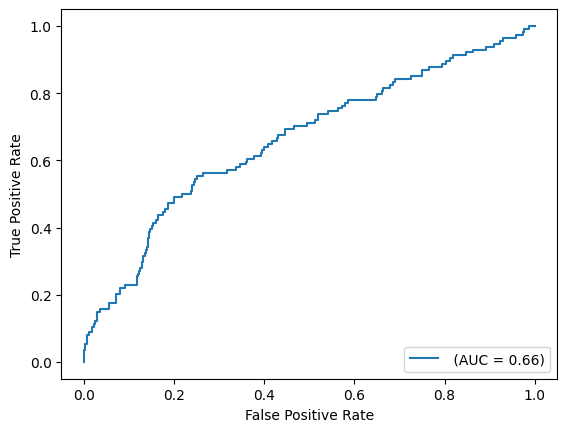

In [45]:
fo_fc_filtered = plot_roc_blob_stats('../pandda_input_models_refined/blob_identification/fo_fc_blob_stats_275_tagged.pkl')

#### check standard Fo-Frecons blobs

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Total Number of Blobs: 11504
Total Number of Unique Samples: 1238


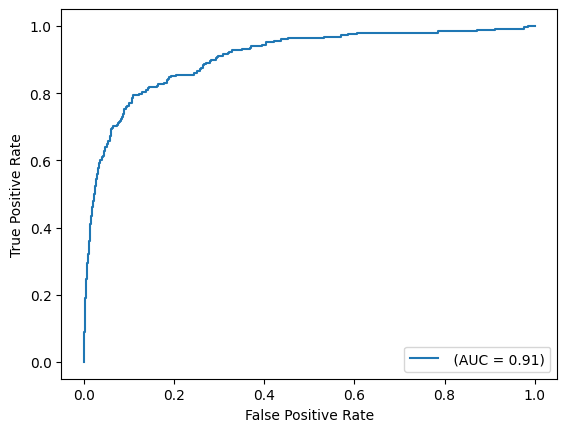

In [46]:
std_blob_stats_df_tagged = tag_blobs('../recons_refined_phases/blob_identification/standard/blob_stats_225_df.pkl')
std_filtered = plot_roc_blob_stats('../recons_refined_phases/blob_identification/standard/blob_stats_225_df_tagged.pkl')

#### check Fo-Frecons blobs

##### Standard

In [85]:
standard_2_3 = check_blob_df('../recons_refined_phases/blob_identification/standard/blob_stats_2_3_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
1402,120935,22.090513,180.420379,22.090518,180.420422,10.994524,263.087022,96.285289,5,5,120935.0,0,Ginn
0654,35871,12.751378,103.304182,12.751378,103.304182,0.990396,122.416609,61.060934,0,3,35871.0,0,Keedy
1629,1257586,188.747175,2109.927175,188.747152,2109.926923,361.554602,1665.882500,550.977085,0,44,1257586.0,0,Keedy
0884,562305,164.297957,1584.500865,164.297957,1584.500865,190.855697,1508.895594,695.276657,0,38,562305.0,0,Keedy
0953,15768,3.915963,27.693766,3.915963,27.693766,-19.190787,57.958230,0.178058,1,1,15768.0,0,Ginn
0432,299565,152.322689,1787.450363,152.322689,1787.450363,122.658022,1411.698133,527.767865,0,35,273868.0,0,Ginn
0994,232253,62.630656,875.525740,62.630644,875.525583,-5.319651,622.318916,118.310154,14,14,232253.0,0,Ginn
0710,74787,26.813081,359.120687,26.813084,359.120730,35.393170,205.022188,96.488850,6,6,0.0,0,Ginn
1163,254696,53.760624,522.219728,53.760631,522.219791,9.624904,598.717157,185.511101,0,13,254696.0,0,Ginn


total no LIG identified near blob in bound state: 13
total bound identified, including bad hg samples: 186
num bad hg samples identified: 4


In [86]:
standard_3_4 = check_blob_df('../recons_refined_phases/blob_identification/standard/blob_stats_3_4_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
1613,728,4.883905,40.680954,4.883905,40.680954,32.109968,8.663679,-0.476264,0,1,728.0,0,Ginn
1860,866,4.625469,55.758093,4.625471,55.758112,-3.140048,62.167329,9.818677,0,1,866.0,0,Ginn
0432,195,5.549019,70.809971,5.549019,70.809971,9.151910,27.182075,4.785403,0,1,195.0,0,Ginn
0245,363,15.621702,167.023621,15.621702,167.023621,-17.679531,121.679499,67.232684,0,3,363.0,0,Ginn
1886,1763,12.050554,124.132832,12.050554,124.132832,-3.273332,80.646512,16.369985,2,2,0.0,0,Ginn
0175,96,5.211193,40.889471,5.211194,40.889476,39.502957,4.056361,2.048499,0,1,96.0,0,Keedy
1530,673,5.604916,64.521673,5.604916,64.521673,-13.833297,60.601644,11.324919,0,1,0.0,0,Ginn
1888,1767,10.837013,80.248976,10.837011,80.248967,-6.122800,87.767169,15.861530,2,2,0.0,0,Ginn
1718,1641,9.699249,87.973517,9.699251,87.973538,12.322328,58.251175,36.308358,0,2,1641.0,0,Ginn


total no LIG identified near blob in bound state: 9
total bound identified, including bad hg samples: 150
num bad hg samples identified: 2


In [87]:
standard_4_5 = check_blob_df('../recons_refined_phases/blob_identification/standard/blob_stats_4_5_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0645,64,17.37742,87.165881,17.377422,87.165892,7.635748,48.380354,25.921978,0,1,64.0,0,Ginn


total no LIG identified near blob in bound state: 1
total bound identified, including bad hg samples: 89
num bad hg samples identified: 2


##### Abs Value + Radius 5 Blur

In [88]:
abs_blur_5_6_rad_5 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_5_min_peak_6/gaussian_abs_val_blur_3d_rad_5_blob_stats_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0884,611,15.134816,185.329295,15.134814,185.329273,4.599816,100.284673,37.031361,0,2,611.0,0,Keedy
1530,522,7.903624,174.096509,7.903623,174.096488,-13.420760,60.531224,11.242804,0,1,0.0,0,Ginn
0241,197,13.498447,515.517606,13.498445,515.517544,-1.426022,105.413742,32.382609,0,2,197.0,0,Ginn
0225,88,7.829111,1542.783336,7.829112,1542.783520,8.377443,40.671032,9.089946,0,1,88.0,0,Ginn
0710,507,17.759231,410.852954,17.759227,410.852856,-23.024850,85.961650,36.896681,2,2,0.0,0,Ginn
0766,539,13.218548,695.492475,13.218552,695.492641,18.756497,95.658914,38.942333,0,2,539.0,0,Keedy
0432,303,13.081608,619.827170,13.081607,619.827133,11.909894,74.353514,59.552584,0,2,303.0,0,Ginn
0559,184,7.391304,474.445858,7.391304,474.445858,-4.116534,49.854503,14.149200,1,1,184.0,0,Keedy
1532,523,6.625625,104.321775,6.625624,104.321756,7.784243,48.802080,26.743513,0,1,523.0,0,Ginn


total no LIG identified near blob in bound state: 18
total bound identified, including bad hg samples: 137
num bad hg samples identified: 2


In [89]:
abs_blur_6_7_rad_5 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_6_min_peak_7/gaussian_abs_val_blur_3d_rad_5_blob_stats_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0645,95,12.424392,973.022680,12.424391,973.022622,7.913772,48.328606,26.289613,0,1,95.0,0,Ginn
1530,252,7.903624,89.655252,7.903623,89.655242,-13.471472,60.578216,11.257055,0,1,0.0,0,Ginn
0225,38,7.829111,682.236527,7.829112,682.236609,8.574754,39.649957,9.206606,0,1,38.0,0,Ginn
0935,150,7.348283,101.053924,7.348283,101.053924,0.821650,63.148289,0.255976,0,1,150.0,0,Ginn
0559,74,7.391304,174.186093,7.391304,174.186093,-4.235446,49.993140,14.101257,1,1,74.0,0,Keedy
0634,93,7.536109,106.240345,7.536108,106.240326,0.243590,60.942235,8.794902,0,1,93.0,0,Ginn
0116,21,10.923797,3741.475634,10.923797,3741.475634,8.109319,39.865687,10.729317,0,1,21.0,0,Keedy
0953,154,8.593968,238.707664,8.593966,238.707607,7.520617,47.845925,26.442153,1,1,154.0,0,Ginn
0646,96,9.289068,1372.620237,9.289068,1372.620237,8.731940,39.211939,8.947205,1,1,96.0,0,Ginn


total no LIG identified near blob in bound state: 14
total bound identified, including bad hg samples: 116
num bad hg samples identified: 2


In [90]:
abs_blur_7_8_rad_5 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_7_min_peak_8/gaussian_abs_val_blur_3d_rad_5_blob_stats_df.pkl')


/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0072,5,12.286640,624.680902,12.286640,624.680902,7.539031,48.249330,25.958555,0,1,5,0,Keedy
0116,12,10.923797,2613.803847,10.923797,2613.803847,8.017597,39.932433,10.904887,0,1,12,0,Keedy
0646,59,9.289068,737.846104,9.289068,737.846104,8.630921,39.174549,8.706061,1,1,59,0,Ginn
0645,58,12.424392,693.190613,12.424391,693.190572,7.882008,48.342867,26.266592,0,1,58,0,Ginn
0953,101,8.593968,109.990186,8.593966,109.990159,7.484834,47.877096,26.443368,1,1,101,0,Ginn
0548,43,8.076160,107.688279,8.076159,107.688254,-4.339599,50.349779,13.798103,1,1,43,0,Ginn


total no LIG identified near blob in bound state: 6
total bound identified, including bad hg samples: 87
num bad hg samples identified: 2


##### Abs Value + Radius 3 Blur

In [91]:
abs_blur_5_6_rad_3 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_5_min_peak_6/gaussian_abs_val_blur_3d_rad_3_blob_stats_df.pkl')


/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0559,398,14.797522,148.620451,14.797520,148.620424,-5.016179,50.490940,14.128129,1,1,398.0,0,Keedy
0953,722,10.036029,202.029723,10.036029,202.029723,7.512356,47.924999,26.544154,1,1,722.0,0,Ginn
1163,907,7.974843,61.176353,7.974844,61.176360,-0.124368,52.366359,35.787248,0,1,907.0,0,Ginn
0710,1593,32.570871,377.857465,32.570875,377.857510,0.042155,104.365290,51.895244,3,3,0.0,0,Ginn
0634,925,21.154226,234.451820,21.154223,234.451792,3.663587,122.620098,21.651680,0,2,925.0,0,Ginn
1530,1187,11.361416,180.533577,11.361416,180.533577,-13.675836,60.653658,11.265529,0,1,0.0,0,Ginn
1532,1188,10.123693,101.246156,10.123693,101.246150,7.600585,48.882451,26.484417,0,1,1188.0,0,Ginn
1613,1271,8.473311,105.178821,8.473310,105.178815,-8.717519,32.333316,0.349715,0,1,1271.0,0,Ginn
1718,1383,8.564570,69.945005,8.564570,69.945005,7.973544,26.345895,6.127110,0,1,1383.0,0,Ginn


total no LIG identified near blob in bound state: 20
total bound identified, including bad hg samples: 174
num bad hg samples identified: 3


In [92]:
abs_blur_6_7_rad_3 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_6_min_peak_7/gaussian_abs_val_blur_3d_rad_3_blob_stats_df.pkl')


/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0953,308,10.036029,126.911764,10.036029,126.911764,7.389164,48.093021,26.332358,1,1,308.0,0,Ginn
0710,447,22.176084,210.797190,22.176086,210.797215,-23.161394,85.820353,36.757418,2,2,0.0,0,Ginn
0679,220,8.252413,74.857295,8.252411,74.857272,0.777146,33.621159,20.904224,0,1,220.0,0,Ginn
0225,165,20.567932,220.627496,20.567929,220.627470,17.717979,78.278283,19.047764,0,2,165.0,0,Ginn
1103,703,28.398856,223.885001,28.398854,223.884988,10.812712,75.678120,48.133227,2,2,703.0,0,Keedy
1304,422,17.611838,180.958857,17.611832,180.958793,7.547276,48.358327,26.127238,1,1,422.0,0,Keedy
1530,483,11.361416,145.121176,11.361416,145.121176,-13.656753,60.653651,11.206306,0,1,0.0,0,Ginn
0548,618,60.454204,485.094172,60.454197,485.094114,-12.494233,202.195614,62.697489,4,4,463.0,0,Ginn
0559,158,14.797522,100.685093,14.797520,100.685075,-4.296909,50.223885,14.063481,1,1,158.0,0,Keedy


total no LIG identified near blob in bound state: 16
total bound identified, including bad hg samples: 153
num bad hg samples identified: 2


In [93]:
abs_blur_7_8_rad_3 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_7_min_peak_8/gaussian_abs_val_blur_3d_rad_3_blob_stats_df.pkl')


/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0646,103,12.727226,229.124923,12.727224,229.124896,7.995711,39.278704,7.960032,1,1,103.0,0,Ginn
1304,239,17.611838,143.557861,17.611832,143.557810,7.473404,48.414502,26.082728,1,1,239.0,0,Keedy
0548,75,19.871247,148.197607,19.871244,148.197589,-3.952043,50.103964,14.119892,1,1,75.0,0,Ginn
0766,136,11.002536,121.215610,11.002536,121.215610,7.267411,48.427028,25.864314,0,1,136.0,0,Keedy
1103,199,13.878878,92.006099,13.878878,92.006094,8.758339,36.047589,34.498471,1,1,199.0,0,Keedy
1530,279,11.361416,103.502002,11.361416,103.502002,-13.596576,60.750695,11.258147,0,1,0.0,0,Ginn
1933,365,12.601080,183.894349,12.601079,183.894327,7.389315,48.300276,25.801085,0,1,365.0,0,Ginn
0072,12,20.090996,737.210049,20.090994,737.209961,7.573273,48.344039,26.027513,0,1,12.0,0,Keedy
0432,62,9.378131,126.639370,9.378132,126.639386,4.932998,26.717960,33.755465,0,1,62.0,0,Ginn


total no LIG identified near blob in bound state: 9
total bound identified, including bad hg samples: 122
num bad hg samples identified: 2


##### Radius 5 Blur

In [94]:
blur_5_6_rad_5 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_5_min_peak_6/gaussian_blur_3d_rad_5_blob_stats_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0678,111,11.442882,1901.010242,11.442884,1901.010696,8.825330,44.315383,29.353971,1,1,0.0,0,Keedy
1530,277,8.928979,285.325574,8.928979,285.325557,-13.474042,60.624009,11.348680,0,1,0.0,0,Ginn
1532,279,6.429428,57.486823,6.429429,57.486830,6.202667,36.985112,0.399313,0,1,279.0,0,Ginn
1163,197,7.110228,71.582929,7.110228,71.582929,-5.493211,75.982917,0.201316,0,1,197.0,0,Ginn
1875,355,6.361420,120.704372,6.361423,120.704415,-6.239097,29.816996,0.387275,0,1,355.0,0,Ginn
0573,87,6.902017,66.435977,6.902018,66.435985,2.688690,76.731700,0.555052,0,1,87.0,0,Keedy
0202,28,6.532768,82.209769,6.532768,82.209769,-5.381497,41.703608,0.187238,0,1,28.0,0,Ginn
1613,297,7.022579,160.288520,7.022578,160.288491,-7.646994,31.747291,0.520768,0,1,297.0,0,Ginn
0710,345,20.982758,227.633835,20.982758,227.633835,0.052731,104.437345,52.787368,3,3,0.0,0,Ginn


total no LIG identified near blob in bound state: 10
total bound identified, including bad hg samples: 94
num bad hg samples identified: 2


In [95]:
blur_6_7_rad_5 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_6_min_peak_7/gaussian_blur_3d_rad_5_blob_stats_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0678,41,11.442882,1479.849854,11.442884,1479.850206,8.755738,44.311739,29.483617,1,1,0.0,0,Keedy
1530,113,8.928979,177.205080,8.928979,177.205069,-13.448933,60.610490,11.345004,0,1,0.0,0,Ginn


total no LIG identified near blob in bound state: 2
total bound identified, including bad hg samples: 61
num bad hg samples identified: 2


In [96]:
blur_7_8_rad_5 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_7_min_peak_8/gaussian_blur_3d_rad_5_blob_stats_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0678,25,11.442882,1083.608381,11.442884,1083.608640,8.643311,44.327510,29.611098,1,1,0.0,0,Keedy
1530,70,8.928979,93.875438,8.928979,93.875433,-13.499672,60.676253,11.353456,0,1,0.0,0,Ginn


total no LIG identified near blob in bound state: 2
total bound identified, including bad hg samples: 43
num bad hg samples identified: 2


##### Radius 3 Blur

In [97]:
blur_5_6_rad_3 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_5_min_peak_6/gaussian_blur_3d_rad_3_blob_stats_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

,index,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,blob_id,ligand,author
sample,,,,,,,,,,,,,
0645,69,15.327473,92.819011,15.327475,92.819022,7.560170,48.473791,25.687724,0,1,69.0,0,Ginn
0676,75,9.144120,86.141788,9.144119,86.141777,25.577830,18.297569,0.286964,0,1,75.0,0,Keedy
1530,178,7.832114,98.095029,7.832112,98.095012,-13.649706,60.740318,11.270189,0,1,0.0,0,Ginn
1613,196,7.537116,102.449438,7.537118,102.449474,-8.252813,31.996322,0.369040,0,1,196.0,0,Ginn
0766,173,13.137502,130.398062,13.137499,130.398039,25.770462,94.232771,28.273921,0,2,173.0,0,Keedy
0432,43,7.441744,85.857221,7.441744,85.857216,9.871480,27.484937,5.276619,0,1,43.0,0,Ginn


total no LIG identified near blob in bound state: 6
total bound identified, including bad hg samples: 111
num bad hg samples identified: 2


In [98]:
blur_6_7_rad_3 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_6_min_peak_7/gaussian_blur_3d_rad_3_blob_stats_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

total no LIG identified near blob in bound state: 0
total bound identified, including bad hg samples: 74
num bad hg samples identified: 2


In [99]:
blur_7_8_rad_3 = check_blob_df('../recons_refined_phases/blob_identification/preprocess/cutoff_7_min_peak_8/gaussian_blur_3d_rad_3_blob_stats_df.pkl')

/tmp/ipykernel_132258/2680250124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blobs_df['author'] = ['Keedy' if author(x)=='Keedy' else 'Ginn' for x in filtered_blobs_df['sample']]


0it [00:00, ?it/s]

total no LIG identified near blob in bound state: 0
total bound identified, including bad hg samples: 52
num bad hg samples identified: 2


#### Tag Cys215 / Tag Lig

In [136]:
tag_blobs('../recons_refined_phases/blob_identification/standard/cutoff_3/blob_stats_df.pkl')
tag_blobs('../recons_refined_phases/blob_identification/standard/cutoff_4/blob_stats_df.pkl')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,volume,radius,reindex,bound,cys215,ligand
0,0032,21.989582,114.807922,21.989574,114.807881,7.516425,48.481913,25.762033,12.512410,1.440182,0,0,1,0
1,0043,29.177810,237.734384,29.177807,237.734356,7.451733,48.335997,25.912328,23.347477,1.773034,1,0,1,0
2,0049,14.108967,332.338640,14.108967,332.338640,-10.805411,61.578768,11.600189,49.919547,2.284164,0,1,0,1
3,0056,8.536923,119.199968,8.536922,119.199961,4.954650,34.290739,15.667325,22.011590,1.738552,0,1,0,1
4,0058,7.342390,72.515396,7.342391,72.515405,8.333561,44.185787,5.143837,14.114396,1.499194,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,1943,6.111808,50.680291,6.111807,50.680282,14.064425,31.660535,18.887945,10.575033,1.361646,0,1,0,0
220,1957,10.901629,182.146113,10.901630,182.146135,8.001908,45.592858,6.763851,29.995208,1.927471,1,1,0,1
221,1957,6.950189,83.325813,6.950190,83.325823,-0.379303,60.077918,10.455529,16.678950,1.584991,1,1,0,1
222,1957,6.693329,57.099143,6.693330,57.099150,11.983511,41.692686,7.622443,11.702166,1.408400,1,1,0,0


#### ROC Curves

Total Number of Blobs: 19997
Total Number of Unique Samples: 1573


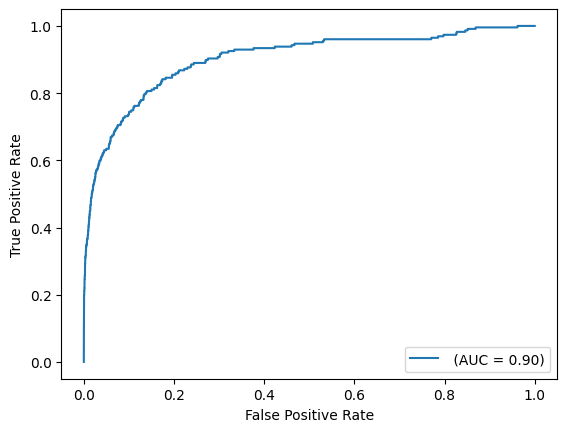

In [17]:
filtered = plot_roc_blob_stats('../recons_refined_phases/blob_identification/preprocess/cutoff_3/gaussian_abs_val_blur_3d_rad_5_blob_stats_df_tagged.pkl')


In [19]:
filtered = filtered.sort_values(by=['scorez'], ascending=False).reset_index(drop=True)
filtered

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,volume,radius,reindex,bound,cys215,ligand
0,0965,10.851485,10853.811549,10.851485,10853.811549,6.881191,31.909884,6.582648,2475.355300,8.391694,0,1,0,1
1,0965,10.851485,10762.129946,10.851485,10762.129946,24.161963,21.942171,-6.652786,2446.771087,8.359268,0,1,0,1
2,1011,9.839128,10468.694175,9.839128,10468.694175,5.259220,34.536545,14.928860,2260.601320,8.141638,0,1,0,1
3,1646,9.811961,9794.623968,9.811963,9794.626303,4.315469,41.421244,12.622971,2359.199008,8.258325,1,1,0,1
4,1264,11.705359,9711.965082,11.705360,9711.966240,24.954945,19.627104,36.400812,1931.798367,7.726054,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992,1771,3.243984,31.050960,3.243984,31.050964,-13.101529,53.486857,7.347303,10.045098,1.338511,1,0,0,0
19993,1344,3.215424,31.040463,3.215423,31.040461,18.304162,38.275947,29.348007,10.070785,1.339651,1,0,0,0
19994,0027,3.166536,30.832131,3.166535,30.832125,-1.948456,44.191547,27.219018,10.064298,1.339363,1,0,0,0
19995,0847,3.150545,30.655459,3.150546,30.655463,-1.378231,45.823584,28.694443,10.001710,1.336581,1,1,0,0


In [70]:
find_nearby_atoms({'x': 6.582648, 'y': 31.909884, 'z': 6.582648}, structure_path('0965'), '0965', 2)

,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,0965,A,1,MET,CE,C,-65.098,21.645,-5.371
1,0965,A,1,MET,HE1,H,-65.435,20.848,-4.954
2,0965,A,1,MET,HE3,H,-64.918,21.479,-6.299
3,0965,A,1,MET,SD,S,-66.281,22.887,-5.242
4,0965,A,1,MET,HG3,H,-67.445,22.251,-7.053


In [69]:
find_nearby_atoms({'x': 24.161963, 'y': 21.942171, 'z': -6.652786}, structure_path('0965'), '0965', 2)

,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,0965,A,1,MET,HG3,H,-67.445,22.251,-7.053
1,0965,A,1,MET,CE,C,-65.098,21.645,-5.371
2,0965,A,1,MET,HE3,H,-64.918,21.479,-6.299
3,0965,A,1,MET,CG,C,-67.608,22.140,-6.104
4,0965,A,1,MET,SD,S,-66.281,22.887,-5.242


In [21]:
sample_0965 = rs.read_mtz(f'../recons_refined_phases/PTP1B_y0965_recons_refined_phases.mtz')

In [61]:
first = move2cell([6.881191, 31.909884, 6.582648], sample_0965.cell)
second = move2cell([24.161963, 21.942171, -6.652786], sample_0965.cell)

In [62]:
first

array([0.2811878 , 0.40944495, 0.06166242])

In [63]:
all_ops = list(sample_0965.spacegroup.operations().sym_ops)
all_ops

[<gemmi.Op("x,y,z")>,
 <gemmi.Op("-y,x-y,z+1/3")>,
 <gemmi.Op("-x+y,-x,z+2/3")>,
 <gemmi.Op("y,x,-z")>,
 <gemmi.Op("x-y,-y,-z+2/3")>,
 <gemmi.Op("-x,-x+y,-z+1/3")>]

In [64]:
for op in all_ops:
    print(op.apply_to_xyz(second))

[0.40926627477697536, 0.28154633982186655, 0.9376805710378163]
[-0.28154633982186655, 0.1277199349551088, 1.2710139043711497]
[-0.1277199349551088, -0.40926627477697536, 1.6043472377044832]
[0.28154633982186655, 0.40926627477697536, -0.9376805710378163]
[0.1277199349551088, -0.28154633982186655, -0.27101390437114964]
[-0.40926627477697536, -0.1277199349551088, -0.604347237704483]


In [25]:
def move2cell(cartesian_coordinates, unit_cell, fractionalize=True):
    '''
    Move your points into a unitcell with translational vectors
    
    Parameters
    ----------
    cartesian_coordinates: array-like
        [N_points, 3], cartesian positions of points you want to move
        
    unit_cell, gemmi.UnitCell
        A gemmi unitcell instance
    
    fractionalize: boolean, default True
        If True, output coordinates will be fractional; Or will be cartesians
    
    Returns
    -------
    array-like, coordinates inside the unitcell
    '''
    o2f_matrix = np.array(unit_cell.fractionalization_matrix)
    frac_pos = np.dot(cartesian_coordinates, o2f_matrix.T) 
    frac_pos_incell = frac_pos % 1
    if fractionalize:
        return frac_pos_incell
    else:
        f2o_matrix = np.array(unit_cell.orthogonalization_matrix)
        return np.dot(frac_pos_incell, f2o_matrix.T)

In [20]:
def move2cell(cartesian_coordinates, unit_cell, fractionalize=True):
    '''
    Move your points into a unitcell with translational vectors
    
    Parameters
    ----------
    cartesian_coordinates: array-like
        [N_points, 3], cartesian positions of points you want to move
        
    unit_cell, gemmi.UnitCell
        A gemmi unitcell instance
    
    fractionalize: boolean, default True
        If True, output coordinates will be fractional; Or will be cartesians
    
    Returns
    -------
    array-like, coordinates inside the unitcell
    '''
    o2f_matrix = np.array(unit_cell.fractionalization_matrix)
    frac_pos = np.dot(cartesian_coordinates, o2f_matrix.T) 
    frac_pos_incell = frac_pos % 1
    if fractionalize:
        return frac_pos_incell
    else:
        f2o_matrix = np.array(unit_cell.orthogonalization_matrix)
        return np.dot(frac_pos_incell, f2o_matrix.T)

In [272]:
filtered

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,volume,radius,reindex,bound,cys215,ligand
1681,0654,4.715087,732.088776,4.715086,732.088645,49.541320,4.107653,1.403192,213.660737,3.708617,0,1,0,0
1971,0654,5.026915,634.591398,5.026914,634.591284,-21.494568,45.131786,-1.538530,188.606975,3.557594,0,1,0,0
3703,0654,4.839420,346.690011,4.839419,346.689949,-4.368168,41.002182,-0.223615,98.526032,2.865195,0,1,0,0
3753,0654,4.054809,342.163327,4.054809,342.163266,-17.943748,56.327109,-1.267193,102.467073,2.902899,0,1,0,0
3862,0654,4.292803,331.768100,4.292802,331.768041,11.303165,52.400884,34.494210,98.807535,2.867921,0,1,0,0
5255,0654,4.382201,236.291339,4.382200,236.291296,13.669553,32.375151,34.797454,68.968222,2.544018,0,1,0,0
5575,0654,4.046741,219.288603,4.046740,219.288563,2.635562,48.691475,3.971347,65.308684,2.498201,0,1,0,0
5941,0654,6.629649,204.501593,6.629648,204.501557,-22.985077,36.658928,0.425839,51.796542,2.312441,0,1,0,0
5997,0654,3.948926,202.030617,3.948925,202.030581,4.206121,31.279310,33.232024,60.523134,2.435628,0,1,0,0
6551,0654,4.284770,180.370743,4.284770,180.370710,8.469561,40.306309,33.447271,53.204057,2.333200,0,1,0,0


In [104]:
filtered_bound_samples_found = set(filtered[filtered['ligand']==1]['sample'])

In [105]:
bound_keedy = set(filter(lambda x: author(x) == 'Keedy', bound_samples))

In [106]:
keedy_samples_not_found = list(set(bound_keedy) - filtered_bound_samples_found)
keedy_samples_not_found

['0654', '1629', '0559', '0884', '1103', '0846']

In [268]:
find_nearby_atoms({'x': 24.16, 'y': 21.94, 'z': -6.65}, structure_path('0965'), '0965', 5)

,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,0965,B,1,LIG,C07,C,-65.795,21.376,-11.130
1,0965,B,1,LIG,O01,O,-68.780,19.465,-7.944
2,0965,S,163,HOH,O,O,-67.225,18.617,-5.996
3,0965,A,1,MET,CA,C,-70.059,21.898,-6.275
4,0965,A,1,MET,CB,C,-68.919,22.727,-5.769
5,0965,A,1,MET,CG,C,-67.608,22.140,-6.104
6,0965,A,1,MET,CE,C,-65.098,21.645,-5.371
7,0965,A,1,MET,HA,H,-69.792,21.513,-7.136
8,0965,A,1,MET,HB2,H,-68.968,23.609,-6.169
9,0965,A,1,MET,HG2,H,-67.617,21.197,-5.875


In [269]:
find_nearby_atoms({'x': 6.88, 'y': 31.9, 'z': 6.58}, structure_path('0965'), '0965', 5)

,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,0965,A,3,MET,H,H,-68.253,18.516,-4.645
1,0965,A,3,MET,HB3,H,-66.337,17.910,-3.796
2,0965,A,1,MET,C,C,-70.425,20.810,-5.332
3,0965,A,1,MET,SD,S,-66.281,22.887,-5.242
4,0965,A,1,MET,HB3,H,-68.983,22.797,-4.804
5,0965,A,1,MET,HE1,H,-65.435,20.848,-4.954
6,0965,A,3,MET,HG2,H,-65.455,19.751,-2.982
7,0965,A,4,GLU,H,H,-68.889,20.625,-2.888
8,0965,A,1,MET,HE2,H,-64.296,21.929,-4.927
9,0965,A,275,ILE,HA,H,-63.560,23.255,-3.152


##### checking

In [117]:
filtered = filtered.sort_values(by='scorez', ascending=False).reset_index(drop=True)

In [161]:
filtered = tag_cys_215_blobs(filtered, 5)

0it [00:00, ?it/s]

In [228]:
filtered[filtered['sample'] == '0467']

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,volume,radius,reindex,bound,cys215,ligand
67,0467,5.116263,5140.815928,5.116262,5140.815009,5.944901,62.893164,39.908149,1456.594587,7.032073,0,0,0,0
81,0467,5.339963,4819.601776,5.339962,4819.600914,6.357716,41.769167,3.543713,1358.739871,6.870936,0,0,0,0
82,0467,4.943176,4819.061190,4.943175,4819.060329,32.980558,26.410254,-3.616349,1364.727157,6.881013,0,0,0,0
2720,0467,4.762385,473.100365,4.762384,473.100281,2.252393,54.600329,24.390170,131.158999,3.151881,0,0,0,0
4867,0467,3.807972,258.267465,3.807971,258.267419,11.339809,47.673263,16.632151,78.208932,2.652910,0,0,0,0


In [163]:
filtered[(filtered['ligand']==0) & (filtered['bound']==0) & (filtered['cys215']==0)]

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,cys215,ligand
43,1243,11.748741,6247.250659,11.748744,6247.252149,4.360247,30.760749,15.119952,0,0,0,0
52,1293,6.491709,6006.010807,6.491710,6006.011523,3.169935,67.862810,7.685816,0,0,0,0
57,1293,6.959963,5884.854869,6.959964,5884.855571,30.050777,31.126628,27.372408,0,0,0,0
67,1753,9.950372,5699.724634,9.950374,5699.725313,4.079625,25.511542,33.455017,1,0,0,0
68,1293,6.498916,5693.407140,6.498917,5693.407819,-14.929493,46.833661,43.624590,0,0,0,0
72,0601,5.982218,5585.709247,5.982218,5585.709247,-19.290237,52.926830,-4.488796,0,0,0,0
73,1753,10.491038,5579.409462,10.491039,5579.410127,-24.911784,61.553164,-1.988760,1,0,0,0
80,1026,5.003549,5357.994175,5.003549,5357.994175,3.295806,62.658445,15.706812,0,0,0,0
83,0736,4.859472,5290.092437,4.859471,5290.091176,51.113428,13.518547,5.198402,0,0,0,0
84,0283,6.027841,5245.776143,6.027840,5245.775205,49.368055,12.447478,4.378439,0,0,0,0


In [186]:
idx = 0

In [187]:
row = filtered.loc[idx]
sample = row['sample']

if row['bound'] == 1 and author(sample) == 'Keedy':
    structure_path = f'../PTP1B_DK/original_data/bound_state_models_reindexed/PTP1B_y{sample}_bound_state_reindexed.pdb'
    print("Bound: Keedy")
elif row['bound'] == 1 and author(sample) == 'Ginn':
    structure_path = f'../PTP1B_DK/original_data/cluster_4x_models_reindexed/y{sample}_cluster4x_model_reindexed.pdb'
    print("Bound: Ginn")
else:
    structure_path = f'../pandda_input_models_refined/PTP1B_y{sample}_pandda_input_reindexed_refine_001.pdb'
    print("Not Bound")

nearby_atoms = find_nearby_atoms({"x": row['cenx'], "y": row['ceny'], "z": row['cenz']}, structure_path, sample, radius=20)
print("LIG found" if "LIG" in nearby_atoms['residue'] else "No LIG found")
nearby_atoms

Bound: Keedy
No LIG found


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,0965,A,5,LYS,CA,C,-72.656,20.576,-0.572
1,0965,A,5,LYS,C,C,-72.379,19.575,0.570
2,0965,A,5,LYS,O,O,-72.885,19.725,1.654
3,0965,A,5,LYS,CB,C,-73.514,19.978,-1.672
4,0965,A,5,LYS,CG,C,-74.651,20.858,-2.150
...,...,...,...,...,...,...,...,...,...
1935,0965,S,170,HOH,O,O,-39.424,3.147,15.757
1936,0965,S,177,HOH,O,O,-37.425,3.480,16.458
1937,0965,S,180,HOH,O,O,-49.760,29.287,-10.944
1938,0965,S,222,HOH,O,O,-39.617,15.952,17.834


In [148]:
oxidation_corr = pd.read_csv('../diff_map_corr/diff_mapp_corr_ROI.csv')

In [158]:
oxidation_corr[oxidation_corr['dataid']==1216]

,1oet_1o,1oeu_2o,1oev_3o,1oeo_3o,dh1194_3o,dataid
964,0.00378,-0.013358,-0.017671,-0.018091,-0.006067,1216


#### radiation damage

In [56]:
cutoff_3_blob_df = pd.read_pickle('../recons_refined_phases/blob_identification/standard_negative/blob_stats_2_negative_df.pkl')

In [ ]:
def check_co2(df):
    
    def check_elements(df):
        for residue, group in df.groupby('residue'):
            if ((group['element'] == 'C').sum() >= 1) and ((group['element'] == 'O').sum() >= 2):
                return True
        return False
        
    result_indicators = []
    all_nearby_atoms = pd.DataFrame()

    for idx, row in tqdm(df.iterrows()):

        nearby_atoms_df = find_nearby_atoms({"x": row['cenx'], "y": row['ceny'], "z": row['cenz']}, 
              f'../pandda_input_models_refined/PTP1B_y{row["sample"]}_pandda_input_reindexed_refine_001.pdb', 
              row['sample'], 
              radius=2)
        nearby_atoms_df['blob_id'] = [idx for x in range(len(nearby_atoms_df))]
        all_nearby_atoms = pd.concat([all_nearby_atoms, nearby_atoms_df])
        
        if len(nearby_atoms_df) > 0:
            co2_indicator = check_elements(nearby_atoms_df)
            result_indicators.append(co2_indicator)
            
        else:
            result_indicators.append(False)

    df['near_co2'] = result_indicators
    
    return df, all_nearby_atoms        

In [58]:
tagged_co2, all_nearby_atoms = check_co2(cutoff_3_blob_df)

0it [00:00, ?it/s]

In [59]:
tagged_co2_counts = tagged_co2[['sample', 'near_co2']]
tagged_co2_counts['count'] = [1 for x in range(len(tagged_co2_counts))]
tagged_co2_counts = tagged_co2_counts.groupby('sample').sum()
tagged_co2_counts = tagged_co2_counts.sort_values(by=['near_co2'], ascending=False)
tagged_co2_counts = tagged_co2_counts[tagged_co2_counts['near_co2'] > 0]

/tmp/ipykernel_196053/3738131720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_co2_counts['count'] = [1 for x in range(len(tagged_co2_counts))]


##### Is radiation damage at the same place? 

In [80]:
confirmed_rad_dmg = [131, 927, 992, 1089, 1103, 1104, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1115, 1117, 1467, 1583, 1594, 1621, 1674, 1876, 1920]
confirmed_rad_dmg_str = [str(num).zfill(4) for num in confirmed_rad_dmg]

In [83]:
cutoff_2_blob_df = pd.read_pickle('../recons_refined_phases/blob_identification/standard_negative/blob_stats_2_negative_df.pkl')

In [84]:
cutoff_2_blob_df = cutoff_2_blob_df[cutoff_2_blob_df['sample'].isin(confirmed_rad_dmg_str)]

In [88]:
filtered_tag_co2, all_nearby_atoms = check_co2(cutoff_2_blob_df)

0it [00:00, ?it/s]

In [91]:
filtered_only_co2 = filtered_tag_co2[filtered_tag_co2['near_co2']==1]

In [93]:
filtered_only_co2, all_nearby_atoms = check_co2(filtered_only_co2)

0it [00:00, ?it/s]

/tmp/ipykernel_198571/2648524215.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['near_co2'] = result_indicators


In [98]:
Counter(all_nearby_atoms['seqid'])

Counter({159: 45,
         132: 68,
         161: 48,
         147: 35,
         29: 43,
         200: 35,
         236: 44,
         148: 31,
         115: 47,
         76: 47,
         245: 37,
         129: 24,
         6: 8,
         65: 21,
         137: 17,
         240: 7,
         265: 7,
         53: 35,
         181: 7,
         207: 29,
         252: 6,
         56: 1,
         26: 8,
         130: 7,
         170: 4,
         500: 1,
         75: 4,
         97: 4})

In [114]:
seqid_lst = [129, 130, 132, 6, 137, 265, 147, 148, 26, 29, 159, 161, 170, 53, 181, 65, 200, 75, 76, 207, 97, 236, 240, 115, 245, 252]


In [115]:
all_nearby_atoms[all_nearby_atoms['seqid'] == 129]

,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz,blob_id
0,0927,A,129,GLU,OE1,O,-26.041,35.144,2.366,12774
1,0927,A,129,GLU,CG,C,-25.315,34.108,0.336,12774
2,0927,A,129,GLU,CD,C,-26.220,35.032,1.133,12774
3,0927,A,129,GLU,OE2,O,-27.112,35.651,0.508,12774
0,1103,A,129,GLU,OE1,O,-26.079,35.347,2.374,15577
1,1103,A,129,GLU,CG,C,-25.313,34.294,0.334,15577
2,1103,A,129,GLU,CD,C,-26.238,35.198,1.132,15577
3,1103,A,129,GLU,OE2,O,-27.165,35.775,0.514,15577
0,1104,A,129,GLU,OE1,O,-26.100,35.289,2.359,15634
1,1104,A,129,GLU,CG,C,-25.360,34.236,0.336,15634


#### Get "false positive" sample where radiation damage is the reason for the signal. DK does not find a ligand.

In [32]:
filtered_tag_co2, all_nearby_atoms = check_co2(filtered)

0it [00:00, ?it/s]

In [43]:
predicted_radiation_dmg = [131, 927, 992, 1089, 1103, 1104, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1115, 1117, 1467, 1583, 1585, 1594, 1612, 1674, 1876, 1920]
predicted_radiation_dmg = [str(num).zfill(4) for num in predicted_radiation_dmg]

In [44]:
filtered_rad_dmg = filtered_tag_co2[filtered_tag_co2['sample'].isin(predicted_radiation_dmg)]

In [45]:
blob_filtered_rad_dmg = filtered_rad_dmg[filtered_rad_dmg['ligand'] == 0]
blob_filtered_rad_dmg

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,cys215,ligand,near_co2
623,0992,6.849067,2346.158908,6.849067,2346.158909,10.652873,41.415760,30.129037,0,0,0,0,False
654,1115,6.168142,2280.039638,6.168141,2280.039502,-11.095653,50.416478,-6.473562,0,0,0,0,False
695,1108,5.270888,2200.477239,5.270888,2200.477239,49.522220,0.818873,12.393395,1,0,0,0,False
787,1109,6.422380,1983.772895,6.422380,1983.773132,-11.811033,50.807573,-4.729364,0,0,0,0,False
850,1108,5.211842,1843.611771,5.211842,1843.611771,19.592503,35.076918,23.272227,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19908,1107,3.525647,33.895463,3.525647,33.895461,10.645047,34.543024,29.987296,0,0,0,0,False
19910,1594,3.337936,33.888504,3.337937,33.888508,-15.480677,47.391558,7.950311,0,1,0,0,False
19924,1112,4.008491,33.821684,4.008491,33.821684,-11.153368,37.865969,3.999834,1,0,0,0,False
20061,1920,3.909914,33.233581,3.909914,33.233581,4.295286,53.546609,9.443846,0,0,0,0,True


In [46]:
blob_filtered_rad_dmg = blob_filtered_rad_dmg[blob_filtered_rad_dmg['near_co2'] == True]

In [51]:
blob_filtered_rad_dmg.head(20)

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,cys215,ligand,near_co2
2270,0992,7.415855,679.510462,7.415855,679.510462,3.537264,74.799731,5.453368,0,0,0,0,True
3168,1110,9.258371,472.229065,9.258369,472.229008,1.917781,40.669306,14.987555,1,0,0,0,True
3740,1112,7.698005,390.239337,7.698005,390.239337,2.329863,39.632622,14.754326,1,0,0,0,True
3779,1109,5.488442,386.304768,5.488443,386.304814,3.936630,74.665648,6.009254,0,0,0,0,True
3835,1109,5.859166,379.159394,5.859167,379.159439,23.548036,34.222753,29.857456,0,0,0,0,True
4728,1104,6.027420,298.403257,6.027420,298.403240,0.871537,51.488685,22.156041,1,0,0,0,True
5366,1103,4.762372,254.379455,4.762372,254.379455,4.218429,74.521376,5.334407,1,1,0,0,True
5555,1594,6.945744,243.426013,6.945745,243.426042,2.402560,39.841829,13.471899,0,1,0,0,True
5723,1103,4.584955,234.769553,4.584955,234.769553,23.272893,33.519875,30.246791,1,1,0,0,True
5932,1104,8.238912,223.643226,8.238912,223.643213,2.335366,39.731595,13.449864,1,0,0,0,True


In [49]:
blob_filtered_rad_dmg.to_pickle('../recons_refined_phases/blob_identification/radiation_dmg/false_positives.pkl')

In [40]:
for idx, row in blob_filtered_rad_dmg.iterrows():
    sample = row['sample']
    display(find_nearby_atoms({"x": row['cenx'], "y": row['ceny'], "z": row['cenz']}, 
                      f'../pandda_input_models_refined/PTP1B_y{sample}_pandda_input_reindexed_refine_001.pdb', 
                      sample, 
                      radius=2))

,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,0992,A,53,ASP,CA,C,-41.280,-1.664,3.904
1,0992,A,53,ASP,CB,C,-41.077,-3.132,4.286
2,0992,A,53,ASP,CG,C,-40.639,-3.312,5.738
3,0992,A,53,ASP,OD1,O,-39.827,-2.501,6.241
4,0992,A,53,ASP,OD2,O,-41.108,-4.276,6.386


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1110,A,236,ASP,CG,C,-56.288,21.185,-13.903
1,1110,A,236,ASP,OD1,O,-57.141,21.908,-14.459
2,1110,A,236,ASP,OD2,O,-55.156,21.605,-13.529


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1112,A,236,ASP,CG,C,-56.324,21.200,-13.834
1,1112,A,236,ASP,OD1,O,-57.200,21.895,-14.390
2,1112,A,236,ASP,OD2,O,-55.186,21.639,-13.508


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1109,A,53,ASP,CB,C,-41.177,-3.159,4.309
1,1109,A,53,ASP,CG,C,-40.701,-3.353,5.757
2,1109,A,53,ASP,OD1,O,-39.833,-2.584,6.235
3,1109,A,53,ASP,OD2,O,-41.196,-4.294,6.423


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1109,A,53,ASP,OD1,O,-39.833,-2.584,6.235
1,1109,A,53,ASP,CG,C,-40.701,-3.353,5.757
2,1109,A,53,ASP,OD2,O,-41.196,-4.294,6.423
3,1109,A,53,ASP,CB,C,-41.177,-3.159,4.309


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1104,A,115,GLU,CD,C,-44.141,24.477,14.333
1,1104,A,115,GLU,OE1,O,-45.049,23.732,14.769
2,1104,A,115,GLU,OE2,O,-43.973,24.703,13.107


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1103,A,53,ASP,CB,C,-40.996,-3.120,4.233
1,1103,A,53,ASP,CG,C,-40.559,-3.318,5.703
2,1103,A,53,ASP,OD2,O,-41.060,-4.274,6.359
3,1103,A,53,ASP,OD1,O,-39.707,-2.560,6.217


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1594,A,236,ASP,CB,C,-57.291,20.253,-14.108
1,1594,A,236,ASP,OD1,O,-58.442,22.301,-13.784
2,1594,A,236,ASP,CG,C,-57.340,21.714,-13.773
3,1594,A,236,ASP,OD2,O,-56.253,22.279,-13.512


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1103,A,53,ASP,OD1,O,-39.707,-2.560,6.217
1,1103,A,53,ASP,CG,C,-40.559,-3.318,5.703
2,1103,A,53,ASP,OD2,O,-41.060,-4.274,6.359
3,1103,A,53,ASP,CB,C,-40.996,-3.120,4.233


,sample,chain,seqid,residue,atom,element,coordx,coordy,coordz
0,1104,A,236,ASP,CG,C,-56.331,21.214,-13.896
1,1104,A,236,ASP,OD1,O,-57.202,21.918,-14.455
2,1104,A,236,ASP,OD2,O,-55.191,21.645,-13.566


#### ROC Keedy

In [62]:
def plot_roc_blob_stats_keedy(path, name=''):
    
    blob_stats_df = pd.read_pickle(path)
    
    # remove cysteines
    blob_stats_filtered = blob_stats_df[blob_stats_df['cys215']==0]    
    
    # identify keedy hits
    blob_stats_filtered['author'] = [None if x not in bound_samples else ('Keedy' if author(x)=='Keedy' else 'Ginn') for x in blob_stats_filtered['sample']]
    blob_stats_filtered['keedy'] = [1 if x=='Keedy' else 0 for x in blob_stats_filtered['author']]
    blob_stats_filtered['ligand_keedy'] = (blob_stats_filtered['keedy']) & (blob_stats_filtered['ligand'])

    # filter R factors
    
    r_factors = pd.read_csv('../pandda_input_models_refined/refine_stats.csv', index_col=0)[['data_id', 'Rfree_final']]
    high_r_factors = r_factors.loc[r_factors['Rfree_final'] > 0.4, 'data_id'].astype(str).str.zfill(4)
    blob_stats_filtered = blob_stats_filtered[~blob_stats_filtered['sample'].isin(high_r_factors)]
    
    fpr, tpr, thresholds = metrics.roc_curve(blob_stats_filtered["ligand_keedy"], blob_stats_filtered["scorez"], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot()
        
    return blob_stats_filtered

/tmp/ipykernel_188888/545197169.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blob_stats_filtered['author'] = [None if x not in bound_samples else ('Keedy' if author(x)=='Keedy' else 'Ginn') for x in blob_stats_filtered['sample']]
/tmp/ipykernel_188888/545197169.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blob_stats_filtered['keedy'] = [1 if x=='Keedy' else 0 for x in blob_stats_filtered['author']]
/tmp/ipykernel_188888/545197169.py:11: SettingWithCopyWarning: 
A value is trying to be set on 

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,cys215,ligand,author,keedy,ligand_keedy
0,0001,7.077693,885.233775,7.077692,885.233669,1.535687,73.502371,-1.056941,1,0,0,0,None,0,0
1,0001,5.516327,749.945943,5.516326,749.945854,25.194788,35.193125,36.306322,1,0,0,0,None,0,0
2,0001,5.940290,569.976011,5.940289,569.975943,-12.860758,32.729695,5.191452,1,0,0,0,None,0,0
3,0001,4.441845,387.542419,4.441844,387.542373,-18.436356,43.731188,37.273343,1,0,0,0,None,0,0
4,0001,4.477877,364.543289,4.477876,364.543246,5.371172,38.771395,12.668322,1,0,0,0,None,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38561,1966,4.558270,60.118065,4.558269,60.118050,-12.477373,39.930802,14.862693,0,0,0,0,None,0,0
38562,1966,4.203226,57.729983,4.203225,57.729969,-11.827992,56.405491,3.044459,0,0,0,0,None,0,0
38563,1966,4.541862,52.263495,4.541861,52.263483,-10.573238,58.622601,33.373502,0,0,0,0,None,0,0
38564,1966,4.121616,37.224835,4.121615,37.224826,-13.591104,43.773910,11.338907,0,0,0,0,None,0,0


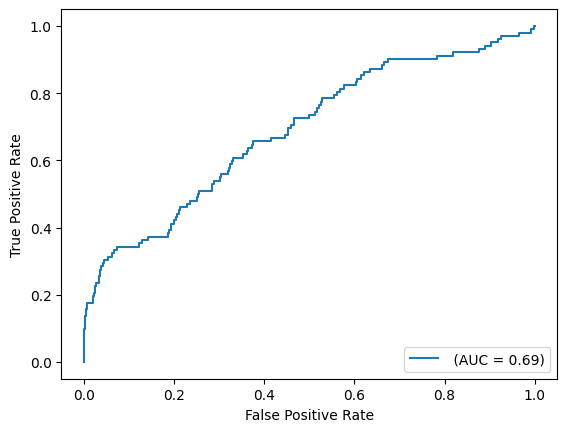

In [71]:
plot_roc_blob_stats_keedy('../pandda_input_models_refined/blob_identification/preprocess/cutoff_3/gaussian_abs_val_blur_3d_rad_5_blob_stats_df_tagged.pkl')


In [63]:
cys215_map_corr = pd.read_csv('../diff_map_corr/diff_mapp_corr_ROI.csv')

In [65]:
cys215_map_corr[cys215_map_corr['dataid']==1487]

,1oet_1o,1oeu_2o,1oev_3o,1oeo_3o,dh1194_3o,dataid
1185,-0.016262,-0.016282,-0.013094,-0.019754,-0.02758,1487


In [81]:
cutoff_4_blob_df['author'] = [None if x not in bound_samples else ('Keedy' if author(x)=='Keedy' else 'Ginn') for x in cutoff_4_blob_df['sample']]

In [82]:
cutoff_4_blob_df.sort_values(by=['scorez'], ascending=False)

,sample,peakz,scorez,peak,score,cenx,ceny,cenz,reindex,bound,cys215,ligand,author
2104,0944,14.287012,9559.443382,14.287010,9559.442243,-0.237164,0.349792,-0.289109,1,0,0,0,None
3588,1539,20.416984,8954.564482,20.416983,8954.563948,0.577878,-0.015433,0.146298,1,0,0,0,None
3589,1539,15.323304,8836.485884,15.323303,8836.485357,-0.188980,0.219768,35.644625,1,0,0,0,None
2105,0944,13.995799,8557.078130,13.995797,8557.077110,-0.236573,-0.814806,35.862988,1,0,0,0,None
3369,1459,23.857870,8486.804421,23.857870,8486.804421,-0.144495,-0.316308,-0.015803,1,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0433,4.259195,41.895060,4.259195,41.895058,36.513645,1.453562,31.517305,1,0,0,0,None
331,0156,4.409125,41.672404,4.409125,41.672404,7.341367,39.082735,29.764456,1,0,0,0,None
2304,1026,4.316342,41.637934,4.316342,41.637934,2.681229,60.536646,11.255853,0,0,1,0,None
60,0036,4.246102,41.450308,4.246101,41.450305,10.315733,39.106264,27.004138,0,0,0,0,None
